In [2]:
import cv2
import matplotlib.pylab as plt
import numpy as np
import time
import random
import pickle

import tensorflow as tf

import keras
import keras.backend as K
from keras.layers import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model


#https://github.com/qubvel/efficientnet
import efficientnet.keras as efn 

import warnings
warnings.filterwarnings('ignore')

print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0-rc2
Keras version: 2.3.1
GPU is available


## Model Load

In [37]:
#Model
num_classes=2

base_model = efn.EfficientNetB0(include_top=False, weights=None, classes=num_classes)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.load_weights('../models/efficientnet_b0_aug_last_weights_120_best.h5')

## TEST

(224, 224, 3)


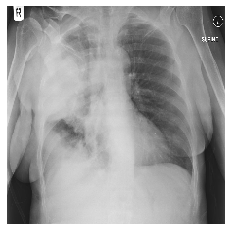

[[0.00710012 0.9928999 ]]
prediction class:  covid19
Time (sec): 0.01


In [41]:
#covid19
#my_test_path = "../datasets/test_images/covid19/23E99E2E-447C-46E5-8EB2-D35D12473C39.png"
#my_test_path = "../datasets/test_images/covid19/ciaa199.pdf-001-c.png"
my_test_path = "../datasets/test_images/covid19/streptococcus-pneumoniae-pneumonia-1.jpg"

#normal

#my_test_path = "../datasets/test_images/normal/IM-0001-0001.jpeg"
#my_test_path = "../datasets/test_images/normal/NORMAL2-IM-0364-0001.jpeg"
#my_test_path = "../datasets/test_images/normal/NORMAL2-IM-0373-0001.jpeg"

target_size = (224, 224)

img2 = cv2.imread(my_test_path)
img2 = cv2.resize(img2, target_size)

b,g,r = cv2.split(img2)       # get b,g,r
img2 = cv2.merge([r,g,b])

print(img2.shape)

plt.imshow(img2)
plt.axis('off')
plt.show()

img2 = np.array(img2, dtype="float") / 255.0
data2 = np.expand_dims(img2, axis=0)

#START TIME
start_time = time.time()

result_pred = model.predict(data2, batch_size=1) 
print(result_pred)

#END TIME
delta = (time.time() - start_time)

labels = ["normal", "covid19"]
bestclass = labels[np.argmax(result_pred, axis=1)[0]]

print("prediction class: ",bestclass)

print("Time (sec): {:.2f}".format(delta))

## Prediction Times

In [17]:
times = []
for i in range(20):
    start_time = time.time()
    ret2 = model.predict(data2, batch_size=1) 
    delta = (time.time() - start_time)
    times.append(delta)
    print('time (sec): {:.2f}'.format(delta))
    
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

time (sec): 0.02
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
time (sec): 0.01
average(sec):0.01,fps:93.86


In [18]:
#val
with open('../datasets/X_val.pickle', 'rb') as f:
    X_val = pickle.load(f)
    
with open('../datasets/y_val.pickle', 'rb') as f:
    y_val = pickle.load(f)
    
print("shape X_val:", X_val.shape)
print("shape y_val:", y_val.shape)

shape X_val: (34, 224, 224, 3)
shape y_val: (34,)


In [28]:
y_val[3]

1

## Random Validation

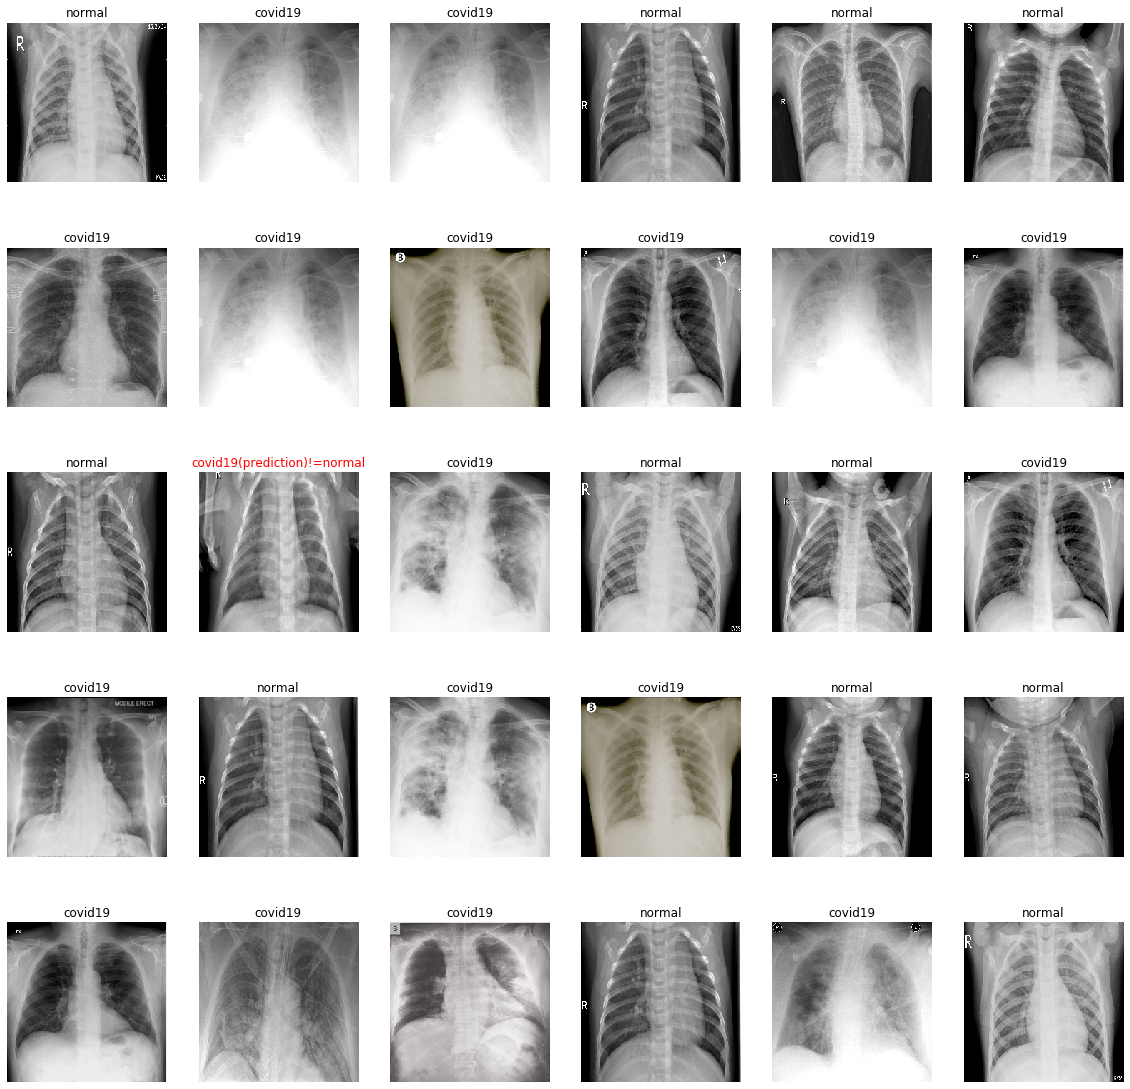

In [35]:
import random
plt.figure(figsize=(20,20))

right = 0
mistake = 0
prefictionNum = 30
target_names = ["normal", "covid19"]

for i in range(prefictionNum):
    index = random.randint(0, X_val.shape[0]-1)
    #print("index", index)
    image = X_val[index]
    data = np.expand_dims(image, axis=0) 
    
    plt.subplot(5, 6, i+1)
    plt.imshow(image)
    plt.axis('off')
    
    result_pred = model.predict(data, batch_size=1) 
    #print("result_pred", result_pred)
    
    bestclass = np.argmax(result_pred, axis=1)[0]
            
    y_class = y_val[index]
    #print("y_class", y_class)
    #print("bestclass", bestclass)
    if y_class == bestclass:
        plt.title(target_names[bestclass])
        right += 1
    else:
        #sagdaki dogru, soldaki prediction sonucu
        plt.title(target_names[bestclass] + "(prediction)!=" + target_names[y_class], color='#ff0000')
        mistake += 1
        
plt.show()